In [1]:
!pip install yfinance

In [2]:
import yfinance as yf # yahoo finance 套件
import pandas as pd # 結構化資料處理套件
import datetime as dt # 時間套件

In [7]:
# 輸入股票代號
stock_id = "3324.TWO" #雙鴻
# stock_id = "2357.tw"
# stock_id = "AAPL"
# stock_id = "NVDA"

'''今天往前算幾天'''
# 資料結束時間
end = dt.date.today()
# 抓取半年資料（現在-過去180天）
start = end - dt.timedelta(days=180)

'''抓取特定時間'''
# start = dt.datetime(2024, 1, 1)  # 指定的開始日期
# end = dt.datetime(2024, 6, 30)    # 指定的結束日期


# 參數1: 股票代號, 參數2: 開始時間, 參數3: 結束時間
df = yf.download(stock_id, start=start, end=end).reset_index()

# 刪除 Ticker 欄位並取代
df.columns = df.columns.droplevel('Ticker')

df

/tmp/ipython-input-3736916778.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(stock_id, start=start, end=end).reset_index()
[*********************100%***********************]  1 of 1 completed


Price,Date,Close,High,Low,Open,Volume
0,2025-03-24,603.320312,632.894838,603.320312,627.965750,1860669
1,2025-03-25,601.348694,618.107592,601.348694,617.121774,2012851
2,2025-03-26,597.405396,608.249388,592.476308,603.320300,1637578
3,2025-03-27,602.334473,602.334473,573.745766,586.561393,2729199
4,2025-03-28,579.660706,594.447968,577.689071,590.504698,2612541
...,...,...,...,...,...,...
118,2025-09-11,770.000000,794.000000,742.000000,748.000000,13573223
119,2025-09-12,781.000000,794.000000,772.000000,790.000000,8380555
120,2025-09-15,829.000000,855.000000,800.000000,800.000000,15994078
121,2025-09-16,828.000000,853.000000,817.000000,838.000000,9332989


1. 技術指標的計算
相對強弱指數（RSI）、平滑異同移動平均線（MACD）

In [8]:
# 計算每個交易日的價格變動，即當天收盤價與前一天收盤價的差異
df['Change'] = df['Close'] - df['Close'].shift(1)

# 將變動值中的正數部分視為“Gain”（增益），如果變動為負則記為0
df['Gain'] = df['Change'].apply(lambda x: x if x > 0 else 0)

# 將變動值中的負數部分視為“Loss”（損失），取其絕對值，如果變動為正則記為0
df['Loss'] = df['Change'].apply(lambda x: abs(x) if x < 0 else 0)

df.tail()

# 計算過去14個交易日的平均增益
df['Avg Gain'] = df['Gain'].rolling(window=14).mean()

# 計算過去14個交易日的平均損失
df['Avg Loss'] = df['Loss'].rolling(window=14).mean()

# 計算相對強弱指數的相對強度（RS），即平均增益與平均損失的比值
df['RS'] = df['Avg Gain'] / df['Avg Loss']

# 計算相對強弱指數（RSI），使用RS公式計算出來
df['RSI'] = 100 - (100 / (1 + df['RS']))

# 顯示最後幾行的數據
df.tail()

Price,Date,Close,High,Low,Open,Volume,Change,Gain,Loss,Avg Gain,Avg Loss,RS,RSI
118,2025-09-11,770.0,794.0,742.0,748.0,13573223,44.0,44.0,0.0,10.285714,4.500000,2.285714,69.565217
119,2025-09-12,781.0,794.0,772.0,790.0,8380555,11.0,11.0,0.0,10.214286,4.500000,2.269841,69.417476
120,2025-09-15,829.0,855.0,800.0,800.0,15994078,48.0,48.0,0.0,13.428571,4.500000,2.984127,74.900398
121,2025-09-16,828.0,853.0,817.0,838.0,9332989,-1.0,0.0,1.0,13.428571,4.500000,2.984127,74.900398
122,2025-09-17,816.0,827.0,782.0,825.0,7902434,-12.0,0.0,12.0,13.428571,4.642857,2.892308,74.308300


1.3 計算平滑異同移動平均線（MACD）

In [14]:
'''
第一日
# 平滑係數公式： α = 2 / (span + 1) = 2 / (span + 1)
# α = 2 / (8 + 1) = 2 / (8 + 1) ≈ 0.2222
# 0.2222 * 770.0 + (1-0.2222) * 776.0 = 171.094 + 603.5728 = 774.6668
'''

# 計算8天的指數移動平均線（EMA），並將其存儲在 'EMA_8' 列中
# adjust=False 表示在計算 EMA 時，只考慮當前值和前一個 EMA 的遞歸計算方式，而不考慮所有歷史數據
df['EMA_8'] = df['Close'].ewm(span=8, adjust=False).mean()

# 計算13天的指數移動平均線（EMA），並將其存儲在 'EMA_13' 列中
df['EMA_13'] = df['Close'].ewm(span=13, adjust=False).mean()

# 計算MACD線：8天EMA減去13天EMA，並將其存儲在 'MACD' 列中
df['MACD'] = df['EMA_8'] - df['EMA_13']

# 顯示DataFrame的最後幾行數據
df.tail(3)

Price,Date,Close,High,Low,Open,Volume,Change,Gain,Loss,Avg Gain,Avg Loss,RS,RSI,EMA_8,EMA_13,MACD
120,2025-09-15,829.0,855.0,800.0,800.0,15994078,48.0,48.0,0.0,13.428571,4.500000,2.984127,74.900398,749.361384,729.400602,19.960781
121,2025-09-16,828.0,853.0,817.0,838.0,9332989,-1.0,0.0,1.0,13.428571,4.500000,2.984127,74.900398,766.836632,743.486231,23.350401
122,2025-09-17,816.0,827.0,782.0,825.0,7902434,-12.0,0.0,12.0,13.428571,4.642857,2.892308,74.308300,777.761825,753.845341,23.916484


2. 資料可視化
K 線型態的捕捉

2.1 可視化收盤價折線圖

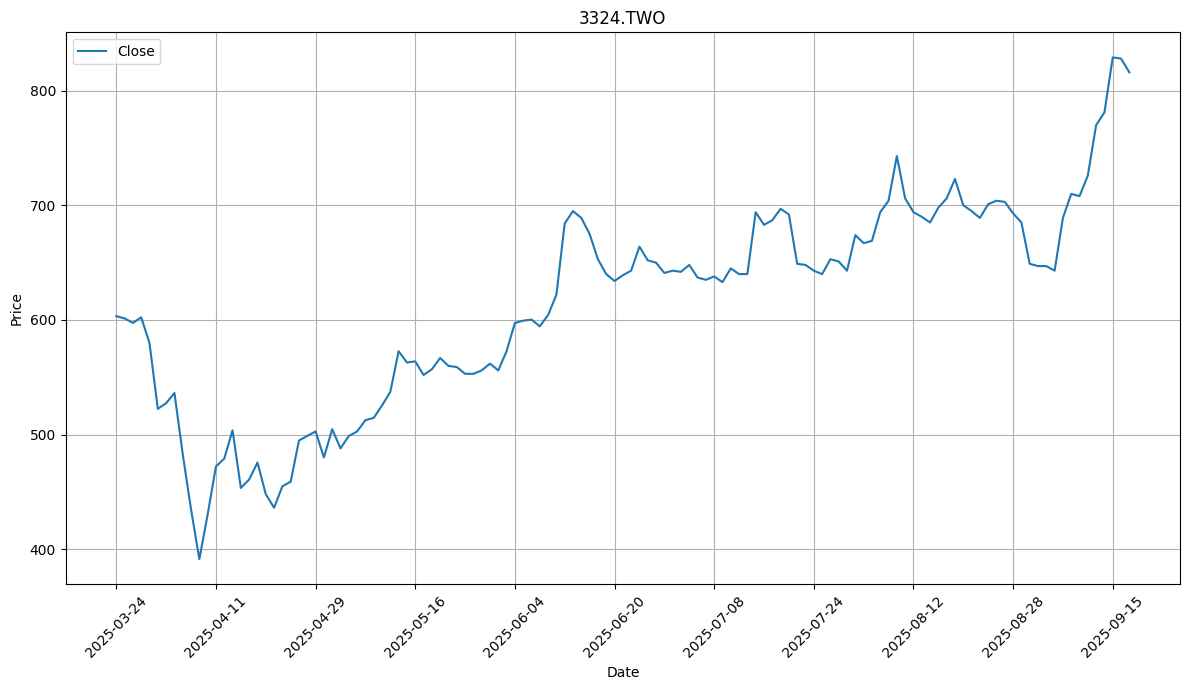

In [15]:
import matplotlib.pyplot as plt

# 畫布尺寸大小設定
plt.figure(figsize=(12, 7))

# 設定要繪製的資料欄位
plt.plot(df['Close'], label='Close')

# 設定 x 軸的時間
num = 10
date = df["Date"].dt.strftime('%Y-%m-%d')
plt.xticks(date[::len(date)//num].index,  # 設定在 x 軸上顯示標籤的位置（索引），這些位置間隔為 len(date)//num
           date[::len(date)//num],  # 設定顯示在 x 軸上的日期標籤，數量為 num，間隔為 len(date)//num
           rotation = 45) # 讓日期標籤旋轉 45 度，以避免標籤之間重疊，提高可讀性

# 設定圖表的標題，x 軸和 y 軸的標籤
plt.title(f'{stock_id}')   # 將股票代號設為圖標
plt.xlabel('Date')         # x 軸標籤
plt.ylabel('Price')  # y 軸標籤
plt.legend(loc='upper left') # 在左上角顯示圖例
plt.grid(True) # 在圖上顯示網格
plt.tight_layout()  # 自動調整圖表中的間距，避免元素之間的重疊

# 顯示圖表
plt.show()

2.2 加入技術指標(macd)

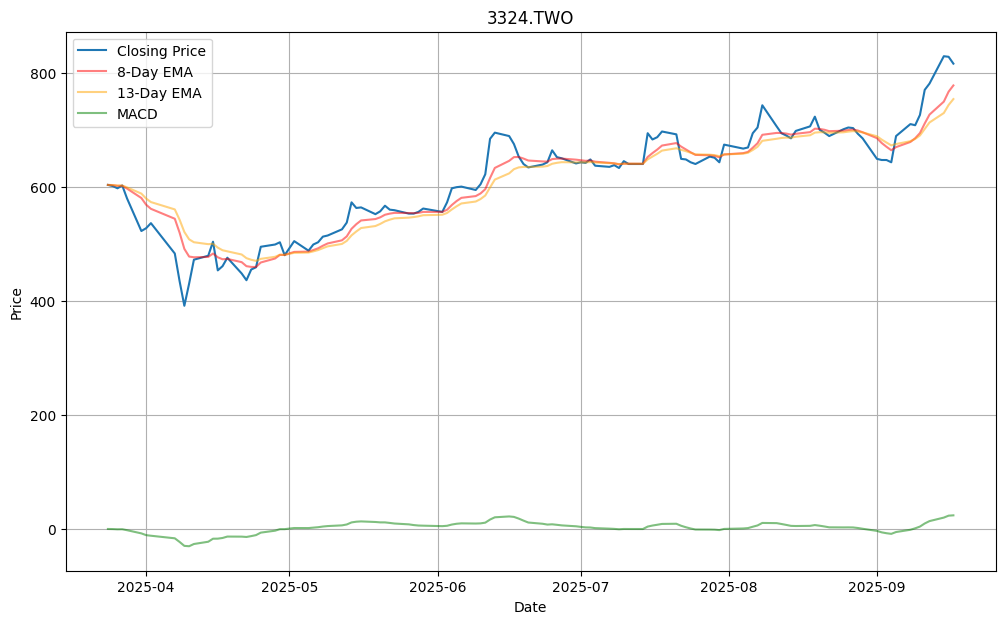

In [16]:
# 畫布尺寸大小設定
plt.figure(figsize=(12, 7))

# 設定要繪製的資料欄位
plt.plot(df['Date'], df['Close'], label='Closing Price')

# 8 天的 EMA
plt.plot(df['Date'], df['EMA_8'], label='8-Day EMA', color='red', alpha=.5)

# 13 天的 SMA
plt.plot(df['Date'], df['EMA_13'], label='13-Day EMA', color='orange', alpha=.5)

# MACD
plt.plot(df['Date'], df['MACD'], label='MACD', color='green', alpha=.5)

# 將股票代號設為圖標
plt.title(f'{stock_id}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

plt.show()

2.3 K 線

In [17]:
!pip install mplfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.1 MB/s eta 0:00:00


In [19]:
# 將原始的 dataframe 再建立一個出來
kplot_df = df.set_index('Date')
kplot_df['2025-08-01':'2025-09-18'].tail()

Price,Close,High,Low,Open,Volume,Change,Gain,Loss,Avg Gain,Avg Loss,RS,RSI,EMA_8,EMA_13,MACD
Date,,,,,,,,,,,,,,,
2025-09-11,770.0,794.0,742.0,748.0,13573223,44.0,44.0,0.0,10.285714,4.500000,2.285714,69.565217,711.066777,701.434153,9.632624
2025-09-12,781.0,794.0,772.0,790.0,8380555,11.0,11.0,0.0,10.214286,4.500000,2.269841,69.417476,726.607493,712.800703,13.806791
2025-09-15,829.0,855.0,800.0,800.0,15994078,48.0,48.0,0.0,13.428571,4.500000,2.984127,74.900398,749.361384,729.400602,19.960781
2025-09-16,828.0,853.0,817.0,838.0,9332989,-1.0,0.0,1.0,13.428571,4.500000,2.984127,74.900398,766.836632,743.486231,23.350401
2025-09-17,816.0,827.0,782.0,825.0,7902434,-12.0,0.0,12.0,13.428571,4.642857,2.892308,74.308300,777.761825,753.845341,23.916484


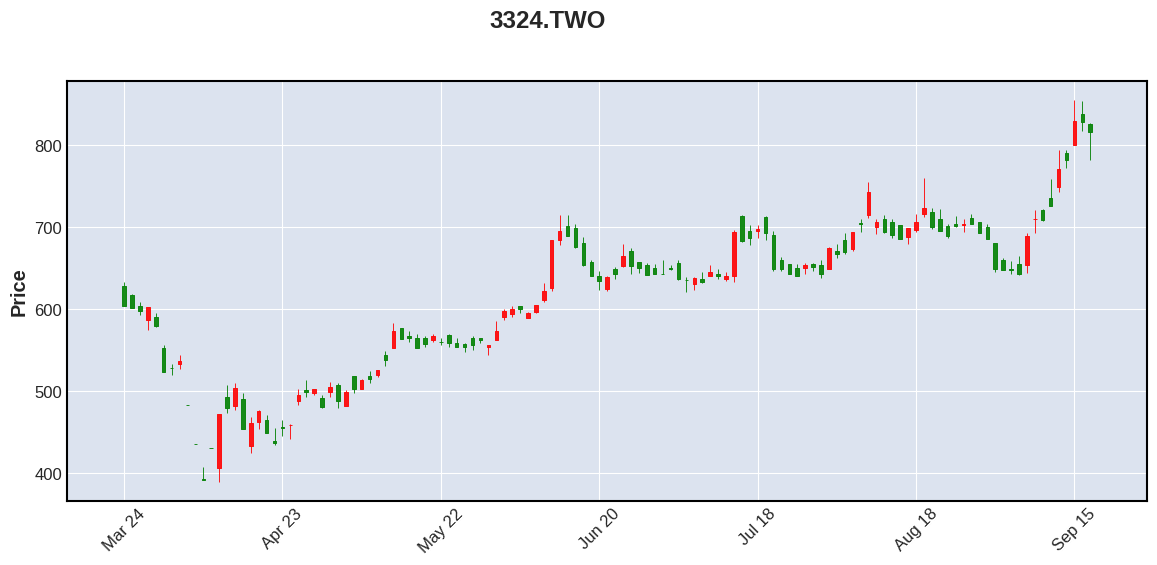

In [20]:
import mplfinance as mpf
# 設置繪圖風格
my_color = mpf.make_marketcolors(up='r', down='g', inherit=True)
my_style = mpf.make_mpf_style(base_mpf_style='default',
                marketcolors=my_color)

# 使用 mplfinance 繪製 K 線圖
mpf.plot(kplot_df, type='candle', style=my_style, title=f'{stock_id}', figsize=(15, 6))

2.4 捕捉 Hammer 型態

In [21]:
# 計算 K 線長度 = abs(收盤-開盤)
df['body_length'] = abs(df['Close'] - df['Open'])

# 計算下影線長度 = abs(最小-最高)
df['lower_shadow'] = abs(df['Low'] - df[['Open', 'Close']].min(axis=1))

# 計算上影線長度 = abs(最高-最小)
df['upper_shadow'] = abs(df['High'] - df[['Open', 'Close']].max(axis=1))

#print('df',df)
# 定義 Hammer 型態的條件
hammer_condition = (
    (df['lower_shadow'] > 2 * df['body_length']) &  # 下影線長於實體的两倍
    (df['upper_shadow'] < df['body_length'] * 0.1) &  # 上影線很短
    (df['body_length'] < (df['High'] - df['Low']) * 0.4)  # 實體相對較小
)

# 提取 Hammer 型態
hammer_df = df[hammer_condition]
hammer_df.set_index('Date', inplace=True)

hammer_df

Price,Close,High,Low,Open,Volume,Change,Gain,Loss,Avg Gain,Avg Loss,RS,RSI,EMA_8,EMA_13,MACD,body_length,lower_shadow,upper_shadow
Date,,,,,,,,,,,,,,,,,,
2025-06-02,556.001038,556.001038,543.185411,554.029403,1569522,-5.914917,0.0,5.914917,5.140329,2.95745,1.738095,63.478257,555.993216,551.027487,4.965729,1.971635,10.843992,0.0


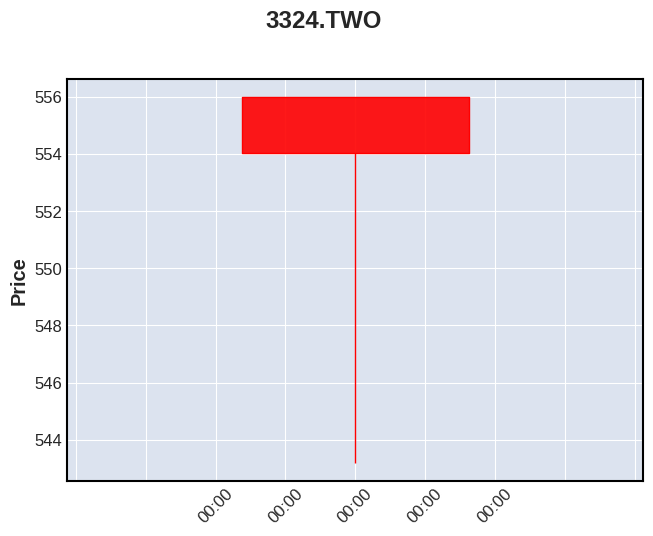

In [22]:
mpf.plot(hammer_df, type='candle', style=my_style, title=f'{stock_id}')

2.5 捕捉 Doji 型態 (十字線）

In [23]:
# 計算 K 線長度
df['body_length'] = abs(df['Close'] - df['Open'])

# 定義Doji型態的條件
# 一般來說，body 長度 如果 小於等於 (最高價-最低價) * 0.1
doji_condition = (
    df['body_length'] <= (df['High'] - df['Low']) * 0.1  # 中間區域非常小
)

# 提取Doji形态
doji_df = df[doji_condition]
doji_df.set_index('Date', inplace=True)

doji_df

Price,Close,High,Low,Open,Volume,Change,Gain,Loss,Avg Gain,Avg Loss,RS,RSI,EMA_8,EMA_13,MACD,body_length,lower_shadow,upper_shadow
Date,,,,,,,,,,,,,,,,,,
2025-04-01,527.412354,532.341441,519.525814,527.412354,3137758,4.929077,4.929077,0.000000,NaN,NaN,NaN,NaN,568.590668,579.419576,-10.828907,0.000000,7.886540,4.929087
2025-04-07,483.050568,483.050568,483.050568,483.050568,160469,-53.234161,0.000000,53.234161,NaN,NaN,NaN,NaN,543.998014,560.370756,-16.372742,0.000000,0.000000,0.000000
2025-04-08,434.745514,434.745514,434.745514,434.745514,1558748,-48.305054,0.000000,48.305054,NaN,NaN,NaN,NaN,519.719681,542.424293,-22.704612,0.000000,0.000000,0.000000
2025-04-09,391.369537,407.635526,391.369537,392.355355,2890408,-43.375977,0.000000,43.375977,NaN,NaN,NaN,NaN,491.197427,520.845042,-29.647616,0.985817,0.000000,15.280171
2025-04-10,430.309326,430.309326,430.309326,430.309326,1055032,38.939789,38.939789,0.000000,NaN,NaN,NaN,NaN,477.666738,507.911369,-30.244631,0.000000,0.000000,0.000000
2025-04-23,454.954773,464.320039,445.096598,455.447682,4986331,18.730530,18.730530,0.000000,11.583359,16.758900,0.691177,40.869568,459.545615,472.038289,-12.492674,0.492909,9.858175,8.872357
2025-04-24,458.898041,459.390950,441.646235,458.405132,6350360,3.943268,3.943268,0.000000,11.231280,16.758900,0.670168,40.125786,459.401710,470.161111,-10.759401,0.492909,16.758897,0.492909
2025-04-28,498.823639,513.610901,492.415825,500.795274,5758819,3.943268,3.943268,0.000000,14.083108,9.506099,1.481481,59.701490,474.294253,477.282606,-2.988353,1.971635,6.407814,12.815627
2025-05-22,559.944336,563.887606,556.001066,559.944336,1209731,-6.900696,0.000000,6.900696,7.182384,3.239114,2.217392,68.918921,552.985849,542.386280,10.599569,0.000000,3.943270,3.943270


In [24]:
doji_df.index

DatetimeIndex(['2025-04-01', '2025-04-07', '2025-04-08', '2025-04-09',
               '2025-04-10', '2025-04-23', '2025-04-24', '2025-04-28',
               '2025-05-22', '2025-07-02', '2025-07-07', '2025-08-07',
               '2025-09-03', '2025-09-08'],
              dtype='datetime64[ns]', name='Date', freq=None)

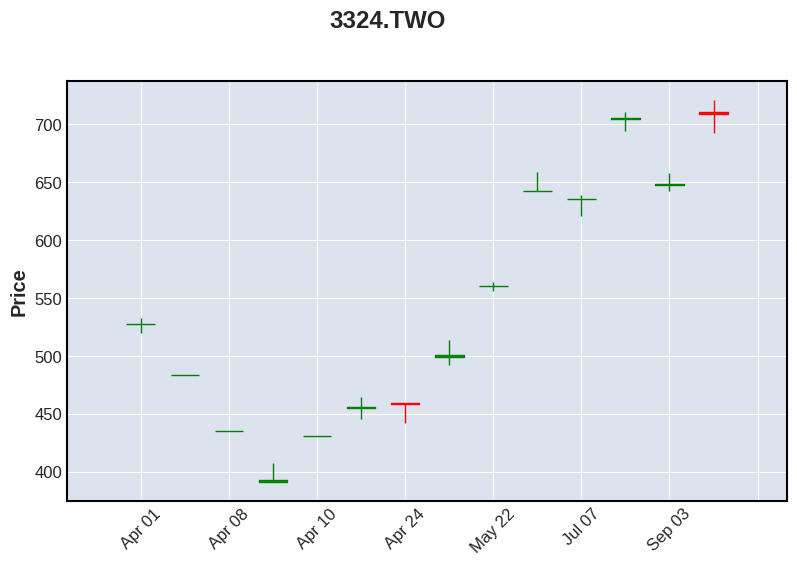

In [27]:
mpf.plot(doji_df, type='candle', style=my_style, title=f'{stock_id}', figsize=(10, 6))

3. 機器學習預測股價漲跌
技術指標當特徵，用線性回歸、決策樹、隨機森林預測股價漲跌

In [29]:
import numpy as np  # 引入 numpy，用於數據處理和數值運算
from sklearn.model_selection import train_test_split  # 引入 train_test_split，用於將數據集拆分為訓練集和測試集
from sklearn.metrics import mean_squared_error  # 引入 mean_squared_error 用於評估模型性能

In [30]:
# 標籤: 預測未來10天的價格，舉例說明:用技術指標預測隔天的收盤價
n = 10
df['Future_Price'] = df['Close'].shift(-n)

# 去除缺失值
df.dropna(inplace=True)

# 使用特徵
X = df[['RSI', 'MACD']]

# 標籤（未來價格）
y = df['Future_Price']

X.shape, y.shape

((100, 2), (100,))

In [31]:
# 將數據集 X 和標籤 y 拆分為訓練集和測試集
# test_size=0.2 表示測試集佔全部數據的 20% --> 80% 的資料作為訓練，20% 的資料作為測試
# shuffle=False 表示在拆分數據時不打亂原始數據的順序
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 查看拆分後訓練集和測試集的形狀
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((80, 2), (20, 2), (80,), (20,))

3.2 線性回歸（Linear Regression）

In [32]:
# 引入線性回歸模型
from sklearn.linear_model import LinearRegression

# 建立並訓練線性回歸模型
model = LinearRegression()
model.fit(X_train, y_train)

# 預測
y_pred = model.predict(X_test)

# 評估
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"線性回歸模型RMSE: {rmse:.2f}")

# 使用模型進行未來價格走勢預測
future_pred = model.predict(X[-1:])  # 使用最新的數據進行預測
print(f"線性回歸模型預測未來{n}天的價格: {future_pred[0]:.2f}")

線性回歸模型RMSE: 97.28
線性回歸模型預測未來10天的價格: 604.31


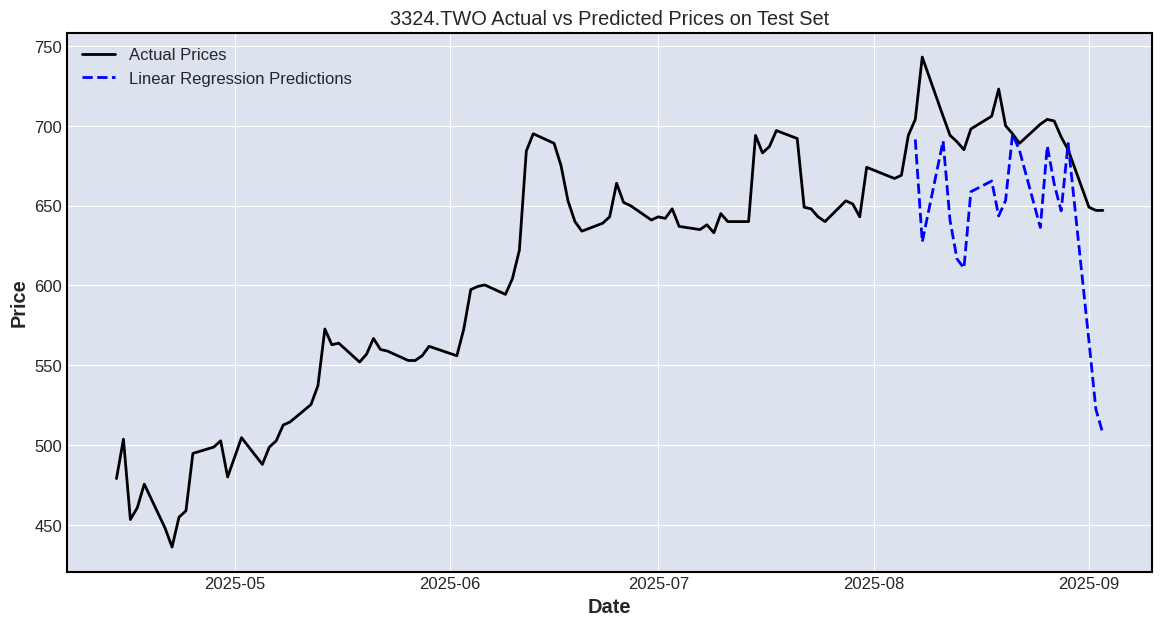

In [37]:
# 畫出測試集的實際價格與預測價格走勢圖
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Close'], label='Actual Prices', color='black', linewidth=2)
plt.plot(df['Date'][-len(y_test):], y_pred, label='Linear Regression Predictions', linestyle='--', color='blue')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('3324.TWO Actual vs Predicted Prices on Test Set')
plt.legend()
plt.grid(True)
plt.show()

3.2 決策樹（Decision Tree）

In [34]:
from sklearn.tree import DecisionTreeRegressor

# 建立並訓練決策數模型
model = DecisionTreeRegressor()
model.fit(X_train, y_train)

# 預測
y_pred = model.predict(X_test)

# 評估
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"決策樹模型RMSE: {rmse:.2f}")

future_pred = model.predict(X[-1:])
print(f"決策樹模型預測未來{n}天的價格: {future_pred[0]:.2f}")

決策樹模型RMSE: 151.65
決策樹模型預測未來10天的價格: 487.98


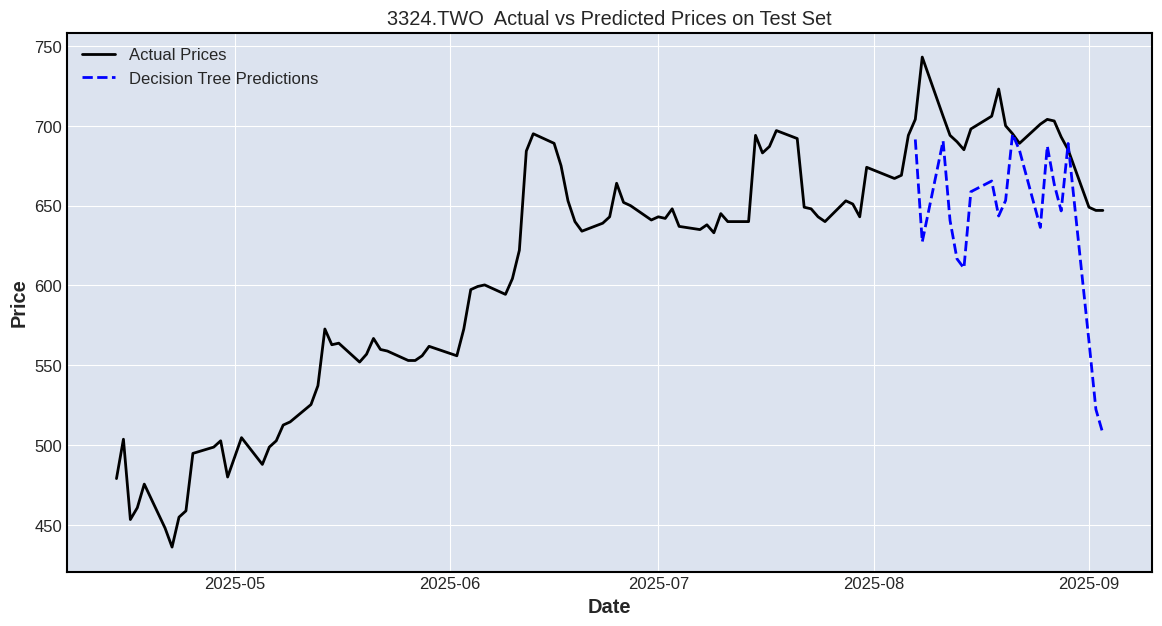

In [38]:
# 畫出測試集的實際價格與預測價格走勢圖
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Close'], label='Actual Prices', color='black', linewidth=2)
plt.plot(df['Date'][-len(y_test):], y_pred, label='Decision Tree Predictions', linestyle='--', color='blue')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('3324.TWO  Actual vs Predicted Prices on Test Set')
plt.legend()
plt.grid(True)
plt.show()

3.3 隨機森林（Random Forest）

In [36]:
# 引入隨機森林模型
from sklearn.ensemble import RandomForestRegressor

# 建立並訓練決策數模型
model = RandomForestRegressor()
model.fit(X_train, y_train)

# 預測
y_pred = model.predict(X_test)

# 評估
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"隨機森林模型RMSE: {rmse:.2f}")

future_pred = model.predict(X[-1:])
print(f"隨機森林模型預測未來{n}天的價格: {future_pred[0]:.2f}")

隨機森林模型RMSE: 126.00
隨機森林模型預測未來10天的價格: 507.40


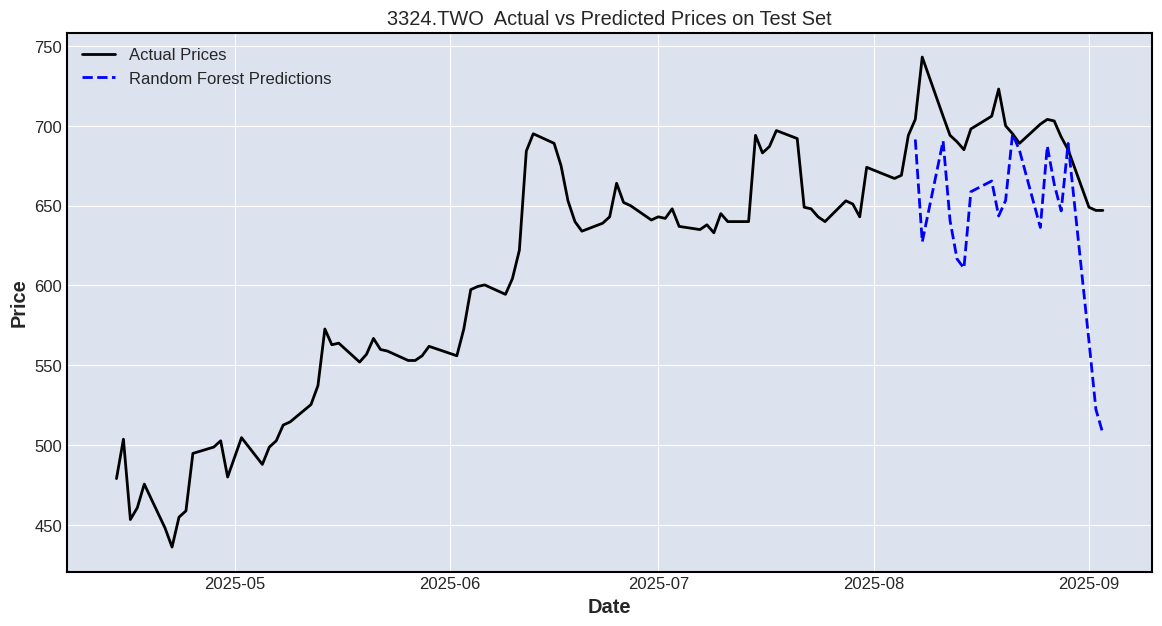

In [39]:
# 畫出測試集的實際價格與預測價格走勢圖
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Close'], label='Actual Prices', color='black', linewidth=2)
plt.plot(df['Date'][-len(y_test):], y_pred, label='Random Forest Predictions', linestyle='--', color='blue')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('3324.TWO  Actual vs Predicted Prices on Test Set')
plt.legend()
plt.grid(True)
plt.show()

補充：在 Colab 上使用中文字體

In [40]:
# Colab 進行matplotlib繪圖時顯示繁體中文
# 下載台北思源黑體並命名taipei_sans_tc_beta.ttf，移至指定路徑
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

import matplotlib

# 改style要在改font之前
# plt.style.use('seaborn')

matplotlib.font_manager.fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
matplotlib.rc('font', family='Taipei Sans TC Beta')

--2025-09-18 08:32:21--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 172.217.214.102, 172.217.214.138, 172.217.214.100, ...
Connecting to drive.google.com (drive.google.com)|172.217.214.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2025-09-18 08:32:21--  https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 108.177.121.132, 2607:f8b0:4001:c19::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|108.177.121.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20659344 (20M) [application/octet-stream]
Saving to: ‘TaipeiSansTCBeta-Regular.ttf’

TaipeiSansTCBeta-Re 100%[===================>]  19.70M  --.-KB/s    in 0.07s   

2025-09-18 

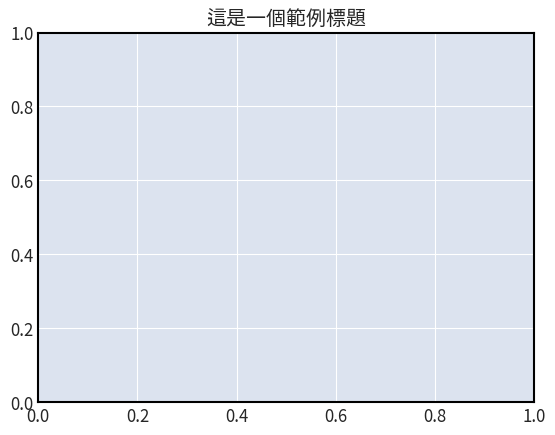

In [41]:
# 繪製範例圖表
plt.title("這是一個範例標題")
plt.show()